# ML Project Assignment - Samuele Ceol

## Classification task on Stroke Prediction Dataset

## Table of Contents
* [CHAPTER 0 - INTRODUCTION](#0)
    * [Section 0.1 - Project rationale & objective](#0.1)
    * [Section 0.2 - Dataset exploration](#0.2)
* [CHAPTER 1 - DATA CURATION](#1)
* [CHAPTER 2 - DEVELOPMENT OF AN ALGORITHM] (#2)
    * [Section 2.1 - Development of a decision tree algorithm] (#2.1) 
    * [Section 2.2 - Development of a random forest algorithm] (#2.2) 
* [CHAPTER 3 - TRAINING THE ALGORITHM](#3)
* [CHAPTER 4 - COMPARING RESULTS WITH AN EXISTING SOLUTION](#4)
* [CHAPTER 5 - CONCLUSIONS](#5)

# CHAPTER 0 - INTRODUCTION <a class="anchor" id="0"></a>

## Section 0.1 - Project rationale & objective <a class="anchor" id="0.1"></a>

## Section 0.2 - Dataset exploration <a class="anchor" id="0.2"></a>

In [1]:
# This block contains all the libraries used in this notebook
import math
import random
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt 
import matplotlib.ticker as mtick

from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, cross_val_score
from collections import Counter
from sklearn.preprocessing import StandardScaler

In [2]:
df = pd.read_csv('data/healthcare-dataset-stroke-data.csv')

df.shape

(5110, 12)

In [3]:
df.head()

id  gender   age  hypertension  heart_disease ever_married  \
0   9046    Male  67.0             0              1          Yes   
1  51676  Female  61.0             0              0          Yes   
2  31112    Male  80.0             0              1          Yes   
3  60182  Female  49.0             0              0          Yes   
4   1665  Female  79.0             1              0          Yes   

       work_type Residence_type  avg_glucose_level   bmi   smoking_status  \
0        Private          Urban             228.69  36.6  formerly smoked   
1  Self-employed          Rural             202.21   NaN     never smoked   
2        Private          Rural             105.92  32.5     never smoked   
3        Private          Urban             171.23  34.4           smokes   
4  Self-employed          Rural             174.12  24.0     never smoked   

   stroke  
0       1  
1       1  
2       1  
3       1  
4       1

In [4]:
print(df.gender.unique())
print(df.ever_married.unique())
print(df.work_type.unique())
print(df.Residence_type.unique())
print(df.smoking_status.unique())

['Male' 'Female' 'Other']
['Yes' 'No']
['Private' 'Self-employed' 'Govt_job' 'children' 'Never_worked']
['Urban' 'Rural']
['formerly smoked' 'never smoked' 'smokes' 'Unknown']


In [5]:
df.isnull().sum()

id                     0
gender                 0
age                    0
hypertension           0
heart_disease          0
ever_married           0
work_type              0
Residence_type         0
avg_glucose_level      0
bmi                  201
smoking_status         0
stroke                 0
dtype: int64

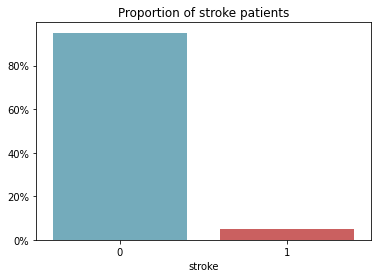

<Figure size 1440x720 with 0 Axes>

In [6]:
def stroke_proportion(curr_df, title):
    g = sns.barplot(
        x='stroke',
        y='stroke',  
        alpha=.75,
        palette=['#3697b5', '#d11313'],
        edgecolor='black',
        linewidth=0,
        data=curr_df,
        estimator=lambda x: len(x) / len(curr_df) * 100
    )
    
    g.yaxis.set_major_formatter(mtick.PercentFormatter())
    g.set_ylabel('')

    plt.title(title)
    plt.figure(figsize=(20, 10))

stroke_proportion(df, "Proportion of stroke patients")

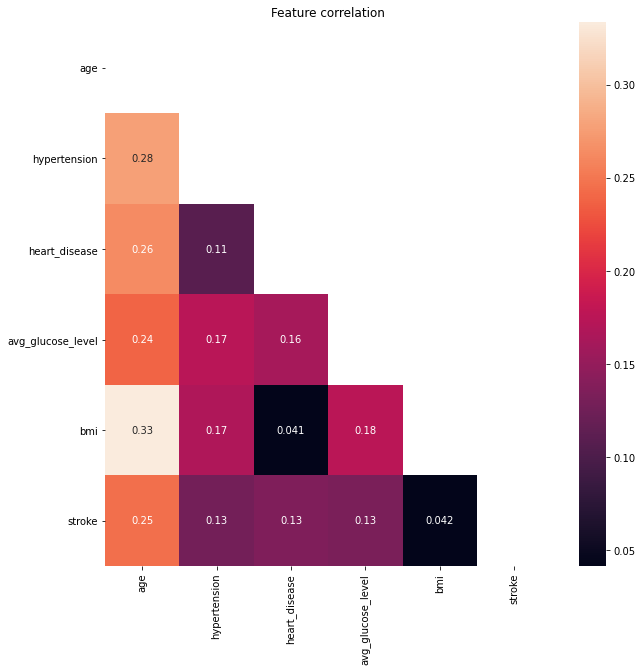

In [8]:
plt.figure(figsize=(10, 10))
plt.title('Feature correlation')

df_corr = df.drop(['id'], axis=1).corr()
mask = np.zeros_like(df_corr, dtype=bool)
mask[np.triu_indices_from(mask)] = True

sns.heatmap(
    df_corr, 
    linecolor='black', 
    mask=mask,
    annot=True)
plt.show()

In [9]:
## Trasforming textual values to numeric 
## gender, ever-married, work_type, Residence_type, smoking_status
cols_to_encode = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

for i in range(len(cols_to_encode)):
    df[cols_to_encode[i]] = LabelEncoder().fit_transform(df[cols_to_encode[i]])

In [10]:
#Since the data is unbalanced, divide it for representation purposes
stroke_df = df[df['stroke'] == 1]
no_stroke_df = df[df['stroke'] == 0]

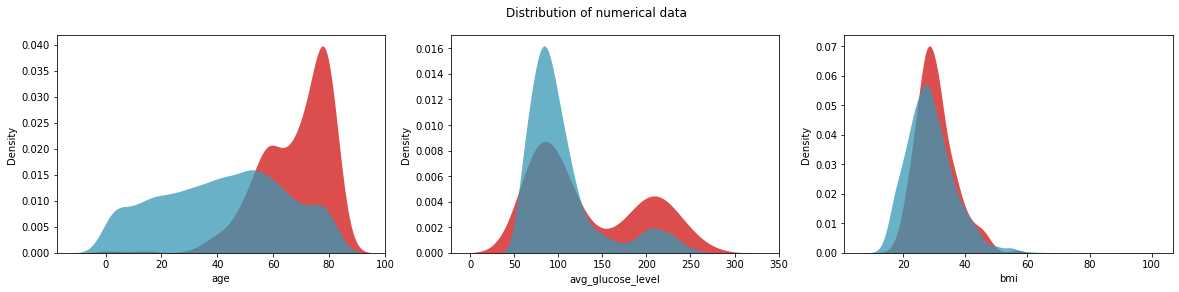

In [11]:
numeric_features = ['age', 'avg_glucose_level', 'bmi']
subplot = 131

fig = plt.figure(figsize=(20, 4))

for i in numeric_features:
    plt.subplot(subplot)

    sns.kdeplot(
        x=i,
        alpha=.75,
        color='#d11313',
        shade=True,
        linewidth=0,
        data=stroke_df
    )

    sns.kdeplot(
        x=i,
        alpha=.75,
        color='#3697b5',
        shade=True,
        linewidth=0,
        data=no_stroke_df
    )

    subplot += 1

plt.suptitle('Distribution of numerical data')
plt.show()

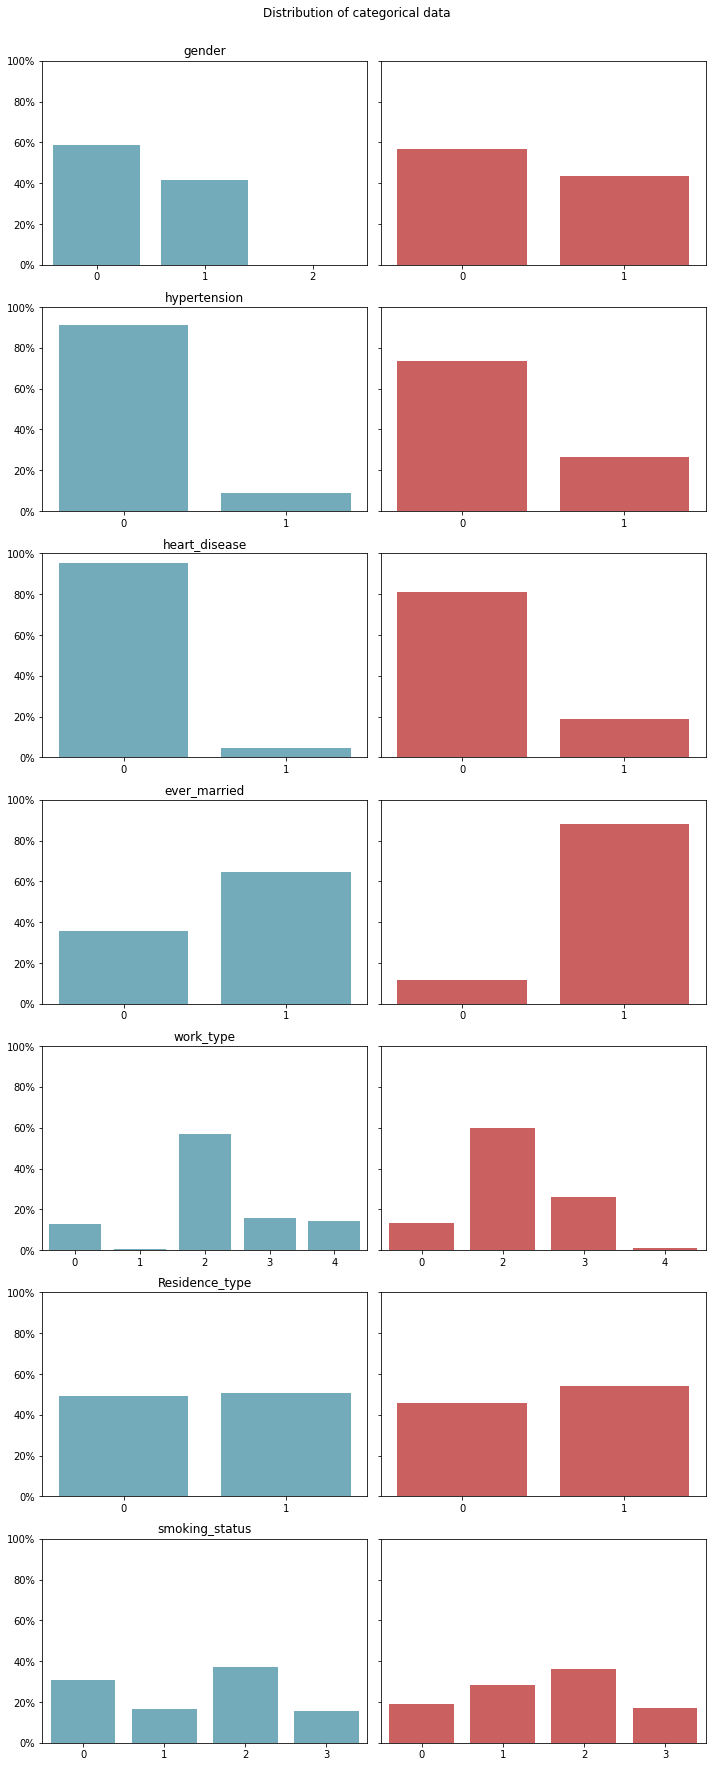

In [12]:
categorical_features = ['gender', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']

fig, ax = plt.subplots(len(categorical_features), 2, figsize=(10, 25), sharey=True)

for i in range(len(categorical_features)):
    feature = categorical_features[i]

    sns.barplot(
        x=feature, 
        y=feature,
        alpha=.75,
        color='#3697b5',
        data=no_stroke_df, 
        estimator=lambda x: len(x) / len(no_stroke_df) * 100,
        ax=ax[i,0]
    )

    sns.barplot(
        x=feature, 
        y=feature,
        alpha=.75,
        color='#d11313', 
        data=stroke_df, 
        estimator=lambda x: len(x) / len(stroke_df) * 100,
        ax=ax[i,1]
    )

    ax[i,0].set_title(feature)
    ax[i,0].set_ylabel('')
    ax[i,1].set_ylabel('')
    ax[i,0].set_xlabel('')
    ax[i,1].set_xlabel('')
    ax[i,0].yaxis.set_major_formatter(mtick.PercentFormatter())

fig.tight_layout()
fig.subplots_adjust(top=0.95)
plt.suptitle('Distribution of categorical data')
plt.show()

# CHAPTER 1 - DATA CURATION <a class="anchor" id="1"></a>

In [13]:
## Removing ids
df = df.drop(['id'], axis=1)

# Encoding categorical data
cols_to_encode = ['gender', 'ever_married', 'work_type', 'Residence_type', 'smoking_status']
for i in range(len(cols_to_encode)):
    df[cols_to_encode[i]] = LabelEncoder().fit_transform(df[cols_to_encode[i]])

# Feature scaling (Standardization) - Removing the median and scaling the data according to the quantile range 
cols_to_scale = ['age', 'avg_glucose_level', 'bmi'] # TODO - Scaling age
ss = StandardScaler()
df[cols_to_scale] = ss.fit_transform(df[cols_to_scale])

# Handling NaN values
#TODO - For now remove
df.dropna(subset = ['bmi'], inplace=True)

## Handling unbalanced data (oversampling with SMOTE)

Synthesizing (training set) entries for the minority class with SMOTE

Shape before SMOTE: (3436, 10)
Shape after SMOTE: (6598, 10)


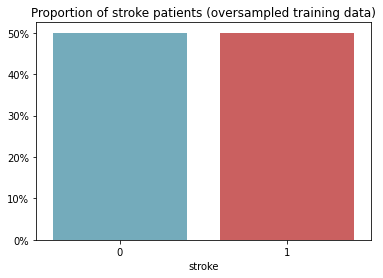

<Figure size 1440x720 with 0 Axes>

In [15]:
X = df[['gender', 'age', 'hypertension', 'heart_disease', 'ever_married', 'work_type', 'Residence_type', 'avg_glucose_level', 'bmi', 'smoking_status']]
y = df[['stroke']]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

oversample = SMOTE()
X_train_SMOTE, y_train_SMOTE = oversample.fit_resample(X_train, y_train)

oversampled_df = X_train_SMOTE.assign(stroke = y_train_SMOTE)
stroke_proportion(y_train_SMOTE, "Proportion of stroke patients (oversampled training data)")
print("Shape before SMOTE: " + str(X_train.shape))
print("Shape after SMOTE: " + str(X_train_SMOTE.shape))

# CHAPTER 2 - DEVELOPMENT OF AN ALGORITHM <a class="anchor" id="2"></a>

## Section 2.1 - Development of a decision tree algorithm <a class="anchor" id="2.1"></a>

In [16]:
# Leaf partitions only have prediction values
class Partition:
    '''
    Class used to represent a partition
    Partitions act as nodes in the Decision Tree

    Attributes
    ----------
    split_feature: str
        Feature chosen for splitting the partition
    split_value: float
        (Threshold) Value chosen for splitting the partition
    impurity_part: float
        Impurity of the current partition
    impurity_delta: float
        Reduction in impurity by splitting using `split_feature` and `split_value`
    impurity_feature_example: float
        Weighted sum of impurities for the partitions resulting from a split at `split_feature` and `split_value`
    prediction: float
        Predicted value (majority class) at the current partition
    '''
    def __init__(self, 
                 split_feature, 
                 split_value, 
                 impurity_part,
                 impurity_delta, 
                 impurity_feature_example, 
                 prediction):
        self.split_feature = split_feature
        self.split_value = split_value
        self.impurity_part = impurity_part
        self.impurity_delta = impurity_delta
        self.impurity_feature_example = impurity_feature_example
        self.prediction = prediction
        self.left_part = None
        self.right_part = None

In [17]:
class DecisionTree:
    '''
    Class used to model the decision tree

    Attributes
    ----------
    strategy: str
        Strategy used to calculate the impurity of a partition
        Either `gini` (for gini index) or `entropy` (for information gain)
    max_depth: int
        Maximum total depth of the tree. Root node is at depth 1
    min_impurity_delta: float
        Threshold for the reduction in impurity needed to split a partition
        If the values is not met, the interested partition is turned into a leaf node
    min_size_part: int
        Threshold for the nr of examples needed to split a partition
        If the values is not met, the interested partition is turned into a leaf node
    max_features: str, int
        The number of features (randomly) considered at each split
        Can be set manually (int) or as follows:
        `None` considers all the features of in training set
        `sqrt` considers the square root of the total nr of features in the training set
        `log2` considers the log base 2 of the total nr of features in the training set
        
    '''
    def __init__(self, *,
                 strategy = 'gini',
                 max_depth = None, 
                 min_impurity_delta = None, 
                 min_impurity_part = None,
                 min_size_part = 2,
                 max_features = None):
        self.strategy = strategy
        self.max_depth = max_depth # Root depth is 0
        self.min_impurity_delta = min_impurity_delta
        self.min_impurity_part = min_impurity_part
        self.min_size_part = min_size_part
        self.max_features = max_features
        self.root = None

    def fit(self, 
            X, 
            y):
        '''
        Starts the process of building a Decision Tree from a training set

        Parameters
        ----------
        X: pandas.core.frame.DataFrame, numpy.ndarray
            The training examples
        y: pandas.core.frame.DataFrame, numpy.ndarray
            The training class labels
        '''
        X, y = self.data_to_numpy(X,y)
        self.root = self.build_tree(X, y, self.max_depth)

    @staticmethod
    def data_to_numpy(X,
                      y = None):
        '''
        Changes input dataframes to numpy arrays

        Parameters
        ----------
        X: pandas.core.frame.DataFrame, numpy.ndarray
            The training examples
        y: pandas.core.frame.DataFrame, numpy.ndarray
            The training class labels

        Returns
        ----------
        X: numpy.ndarray
            The training examples converted to a numpy array
        y: numpy.ndarray
            The training class labels converted to a (flattened) numpy array
        '''
        if(type(X) != np.ndarray):
            X = X.to_numpy()
        if((type(y) != type(None)) and (type(y) != np.ndarray)):
            y = y.to_numpy()

        if(type(y) != type(None)):
            return X, y.flatten()
        else:
            return X

    def build_tree(self, 
                   X, 
                   y, 
                   depth):
        '''
        Recursively builds a Decision Tree starting from a training set.

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            The training examples
        y: numpy.ndarray
            The training class labels
        depth: int
            Depth counter
            Used as stop condition for the recursive call when `max_depth` is defined for the Decision Tree

        Returns
        -------
        curr_part: Partition
            The root partition (node) of the Decision Tree
        '''
        # Majority class is set as the predicted value for the current partition
        #print(Counter(y))
        prediction = Counter(y).most_common(1)[0][0]

        # Update depth value
        if self.max_depth:
            if depth > 0:
                depth -= 1 
            else:
                return Partition(None, None, None, None, None, prediction) # Return as leaf

        # Check partition size
        if y.size < self.min_size_part:
            return Partition(None, None, None, None, None, prediction) # Return as leaf

        split_feature, split_value, impurity_part, impurity_delta, impurity_feature_example = self.find_split(X, y)
        curr_part = Partition(split_feature, split_value, impurity_part, impurity_delta, impurity_feature_example, prediction)
        #print(f"SF: {split_feature}, SV: {split_value}")

        if(split_feature):
            # Temporarely create a merged df in order to filter features and classes together
            merged_df = np.append(X, np.vstack(y), axis=1)
            
            merged_df_left = merged_df[merged_df[:,split_feature] < split_value]
            merged_df_right = merged_df[merged_df[:,split_feature] > split_value]

            #print(f"Shape: {merged_df.shape}, Left: {merged_df_left.shape}, Right: {merged_df_right.shape}")
            #print(f"Split value: {split_value}, Max value: {max(merged_df[:,split_feature])}")

            curr_part.left_part = self.build_tree(
                merged_df_left[:, :-1], 
                merged_df_left[:, -1], 
                depth) # Left

            curr_part.right_part = self.build_tree(
                merged_df_right[:, :-1], 
                merged_df_right[:, -1], 
                depth) # Right  

        return curr_part

    def predict(self, 
                X):
        '''
        Predicts the class value (label) for each input example
        The tree is traversed for each provided example

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            The training examples

        Returns
        ----------
        y: numpy.ndarray
            The predicted class labels
        '''
        X = self.data_to_numpy(X)
        y = []

        for example in X:
            curr_part = self.root

            while curr_part.right_part:
                if example[curr_part.split_feature] < curr_part.split_value:
                    curr_part = curr_part.left_part
                else:
                    curr_part = curr_part.right_part
            y.append(curr_part.prediction)

        return np.array(y)

    # Both gini index and entropy/information gain are measures of the impurity of a node.
    def calc_impurity(self, 
                      class_occ, 
                      size_part):
        '''
        Calculates the impurity of a partition based on the chosen strategy

        Parameters
        ----------
        class_occ: Counter
            Nr of occurrences of each class value 
        size_part:
            Nr of examples in the current partition
        Returns
        ----------
        ret:
            The impurity value of the partition
        '''
        if self.strategy == 'gini':
            return (1 - sum((class_occ[curr_class]/size_part)**2 for curr_class in class_occ))
        elif self.strategy == 'entropy':
            ret = 0
            for curr_class in class_occ:
                if class_occ[curr_class]/size_part > 0:
                    ret -= class_occ[curr_class]/size_part * math.log(class_occ[curr_class]/size_part, 2)
            return ret

    def find_split(self, 
                    X, 
                    y):
            '''
            Finds the best split feature and threshold for a given partition

            Parameters
            ----------
            X: pandas.core.frame.DataFrame
                The training examples
            y: pandas.core.frame.DataFrame
                The training class labels

            Returns
            ----------
            split_feature: str
                Feature chosen for splitting the partition
            split_value: float
                (Threshold) Value chosen for splitting the partition
            impurity_delta: float
                Reduction in impurity by splitting using `split_feature` and `split_value`
            impurity_feature_example: float
                Weighted sum of impurities for the partitions resulting from a split at `split_feature` and `split_value`
            '''
            # Initialize the return values
            split_feature, split_value, impurity_part, impurity_delta, impurity_feature_example = None, None, None, None, None

            # Calculate the occurences of each class in the partition
            class_occ_part = Counter(y)
            #print(class_occ_part)

            # Calculate the impurity of the current partition
            size_part = y.size
            impurity_part = self.calc_impurity(class_occ_part, size_part)

            # Return if below impurity threshold
            if self.min_impurity_part and impurity_part < self.min_impurity_part:
                return split_feature, split_value, impurity_part, impurity_delta, impurity_feature_example

            # Return if the partition is pure
            #print(sum(class_occ_part[i] > 0 for i in class_occ_part) )
            if sum(class_occ_part[i] > 0 for i in class_occ_part) == 1:
                return split_feature, split_value, impurity_part,impurity_delta, impurity_feature_example

            impurity_delta = 0

            # Sample the features to consider for the split
            X_rows, X_cols = X.shape
            n = X_cols

            if self.max_features == 'sqrt':
                n=round(math.sqrt(X_cols))
            elif self.max_features == 'log2':
                n=round(math.log2(X_cols))
            elif self.max_features != None and self.max_features <= X_cols:
                n=self.max_features

            sampled_features = sorted(random.sample(range(0, X_cols), n))

            # Loop through all features
            for feature in sampled_features:
                # Skip ahead if the feature has only one value
                if len(np.unique(X[:,feature])) == 1:
                    continue

                # Sort the examples in increasing order for the selected feature
                # Consider the midpoint between two (different) adjecent values as a possible split point
                feature_sorted, y_sorted = zip(*sorted(zip(X[:,feature], y), key=lambda x: x[0]))

                # Go through the sorted feature while keeping track of class occurences on each side (/partition)
                class_occ_left = Counter({0:0, 1:0}) # TODO - Improve this
                class_occ_right = class_occ_part.copy() # Same as occurences of each class in the partition

                for example in range(1, size_part):
                    example_class = y_sorted[example-1]

                    # Increment the example class on the left, decrement it on the right
                    class_occ_left[example_class] += 1
                    class_occ_right[example_class] -= 1

                    # Skip ahead if two adjacent values are equal
                    if feature_sorted[example] == feature_sorted[example - 1]:
                        continue

                    # Calculate the impurity of each side
                    size_left = example
                    impurity_left = self.calc_impurity(class_occ_left, size_left)

                    size_right = size_part - example
                    impurity_right = self.calc_impurity(class_occ_right, size_right)
                    
                    # Calculate the weighted sum of impurities (obtained with selected feature at current example)
                    curr_impurity_feature_example = ((size_left/size_part) * impurity_left) + ((size_right/size_part) * impurity_right)

                    # Calculate the reduction in impurity with the current split
                    curr_impurity_delta = impurity_part - curr_impurity_feature_example

                    if(self.min_impurity_delta and curr_impurity_delta < self.min_impurity_delta):
                        continue

                    if(curr_impurity_delta > impurity_delta):
                        split_feature = feature
                        split_value = (feature_sorted[example] + feature_sorted[example-1]) / 2
                        impurity_delta = curr_impurity_delta
                        impurity_feature_example = curr_impurity_feature_example

            return split_feature, split_value, impurity_part, impurity_delta, impurity_feature_example

In [62]:
import time
start_time = time.time()
test_tree = DecisionTree()
test_tree.fit(X_train_SMOTE, y_train_SMOTE)
test_tree_pred = test_tree.predict(X_test)
print(f"Run time: {time.time() - start_time}")

Run time: 1.7101829051971436


In [63]:
Counter(test_tree_pred)

Counter({1.0: 207, 0.0: 1266})

In [55]:
Counter(clf_predict)

Counter({1: 192, 0: 1281})

## Section 2.2 - Development of a random forest algorithm <a class="anchor" id="2.2"></a>

In [20]:
class RandomForest:
    '''
    Class used to model the random forest

    Attributes
    ----------
    forest_size: int
        Controls the nr of trees in the forest
    bootstrapping: bool
        Decides whether bootstrapping is used for the trees input data
        When set to False, the whole dataset is used for each tree in the forest
    bootstrapping_ratio: float
            The ratio size of the bootstrapping sample
    strategy: str
        Strategy used to calculate the impurity of a partition in a tree
        Either `gini` (for gini index) or `entropy` (for information gain)
    max_depth: int
        Maximum total depth of the trees. Root node is at depth 1
    min_impurity_delta: float
        Threshold for the reduction in impurity needed to split a partition in a tree
        If the values is not met, the interested partition is turned into a leaf node
    min_size_part: int
        Threshold for the nr of examples needed to split a partition in a tree
        If the values is not met, the interested partition is turned into a leaf node
    max_features: str
        The number of features (randomly) considered at each split in a tree
        `None` considers all the features in the training set
        `sqrt` considers the square root of the total nr of features in the training set
        `log2` considers the log base 2 of the total nr of features in the training set
    '''
    def __init__(self, *,
                 forest_size = 100,
                 bootstrapping = True,
                 bootstrapping_ratio = 1.0,
                 strategy = 'gini',
                 max_depth = None, 
                 min_impurity_delta = None, 
                 min_impurity_part = None,
                 min_size_part = 2,
                 max_features = 'sqrt'):
        self.strategy = strategy
        self.max_depth = max_depth # Root depth is 0
        self.bootstrapping = bootstrapping
        self.bootstrapping_ratio = bootstrapping_ratio
        self.forest_size = forest_size
        self.min_impurity_delta = min_impurity_delta
        self.min_impurity_part = min_impurity_part
        self.min_size_part = min_size_part
        self.max_features = max_features
        self.forest = []

    def fit(self, 
            X, 
            y):
        '''
        Starts the process of building a Random Forest

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            The training examples
        y: numpy.ndarray
            The training class labels
        '''
        X, y = self.data_to_numpy(X, y)

        # Flush old forest
        if len(self.forest) > 0:
            self.forest = []

        for i in range(self.forest_size):
            curr_tree = DecisionTree(strategy = self.strategy,
                                     max_depth = self.max_depth,
                                     min_impurity_delta = self.min_impurity_delta,
                                     min_impurity_part = self.min_impurity_part,
                                     min_size_part = self.min_size_part,
                                     max_features = self.max_features)

            if self.bootstrapping:
                curr_X, curr_y = self.bootstrap(X, y, self.bootstrapping_ratio)
                curr_tree.fit(curr_X, curr_y)
            else:
                curr_tree.fit(X, y)

            self.forest.append(curr_tree)

    @staticmethod
    def data_to_numpy(X,
                      y = None):
        '''
        Changes input dataframes to numpy arrays

        Parameters
        ----------
        X: pandas.core.frame.DataFrame, numpy.ndarray
            The training examples
        y: pandas.core.frame.DataFrame, numpy.ndarray
            The training class labels

        Returns
        ----------
        X: numpy.ndarray
            The training examples converted to a numpy array
        y: numpy.ndarray
            The training class labels converted to a (flattened) numpy array
        '''
        if(type(X) != np.ndarray):
            X = X.to_numpy()
        if((type(y) != type(None)) and (type(y) != np.ndarray)):
            y = y.to_numpy()

        if(type(y) != type(None)):
            return X, y.flatten()
        else: 
            return X

    @staticmethod
    def bootstrap(X, 
                  y, 
                  ratio = 1):
        '''
        Creates a new dataset (X_bootstrap, y_bootstrap) by randomly selecting examples from the original dataset (X, y) 
        until a ratio size is reached
        The same examples from the original dataset may be sampled multiple times (sampling with replacement)

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            The training examples
        y: numpy.ndarray
            The training class labels
        ratio: float
            The ratio size of the sample

        Returns
        ----------
        X_bootstrap: pandas.core.frame.DataFrame
            New feature dataframe created from the sampled entries
        y_bootstrap: numpy.ndarray
            New class dataframe created from the sampled entries
        '''
        # Temporarily create a merged df to sample from
        merged_df = np.append(X, np.vstack(y), axis=1)

        samples_idx = np.random.choice(merged_df.shape[0], round(merged_df.shape[0]*ratio))
        merged_df[samples_idx]

        X_bootstrap = merged_df[:, :-1]
        y_bootstrap = merged_df[:, -1]

        return X_bootstrap, y_bootstrap

    def predict(self, 
                X):
        '''
        Predicts the class value (label) for each input example

        Parameters
        ----------
        X: pandas.core.frame.DataFrame
            The training examples

        Returns
        ----------
        y: numpy.ndarray
            The predicted class labels
        '''
        X = self.data_to_numpy(X)
        y_forest = [] # Each index is the list of predictions from one tree

        for tree in self.forest:
            y_forest.append(tree.predict(X))

        # Zip together prediction for same entry over different trees, extract most common class (majority voting)
        return np.array(list(map(lambda i: Counter(i).most_common(1)[0][0], zip(*y_forest))))

In [21]:
import time
start_time = time.time()
test_forest = RandomForest()
test_forest.fit(X_train_SMOTE, y_train_SMOTE)
test_forest_pred = test_forest.predict(X_test)
print(f"Run time: {time.time() - start_time}")

Run time: 60.30252528190613


In [22]:
Counter(test_forest_pred)

Counter({1.0: 292, 0.0: 1181})

# CHAPTER 3 - TRAINING THE ALGORITHM <a class="anchor" id="3"></a>

# CHAPTER 4 - COMPARING RESULTS WITH AN EXISTING SOLUTION <a class="anchor" id="4"></a>

In [60]:
from sklearn import tree

clf = tree.DecisionTreeClassifier()
clf = clf.fit(X_train_SMOTE, y_train_SMOTE)
clf_predict = clf.predict(X_test)

In [61]:
Counter(clf_predict)

Counter({1: 179, 0: 1294})

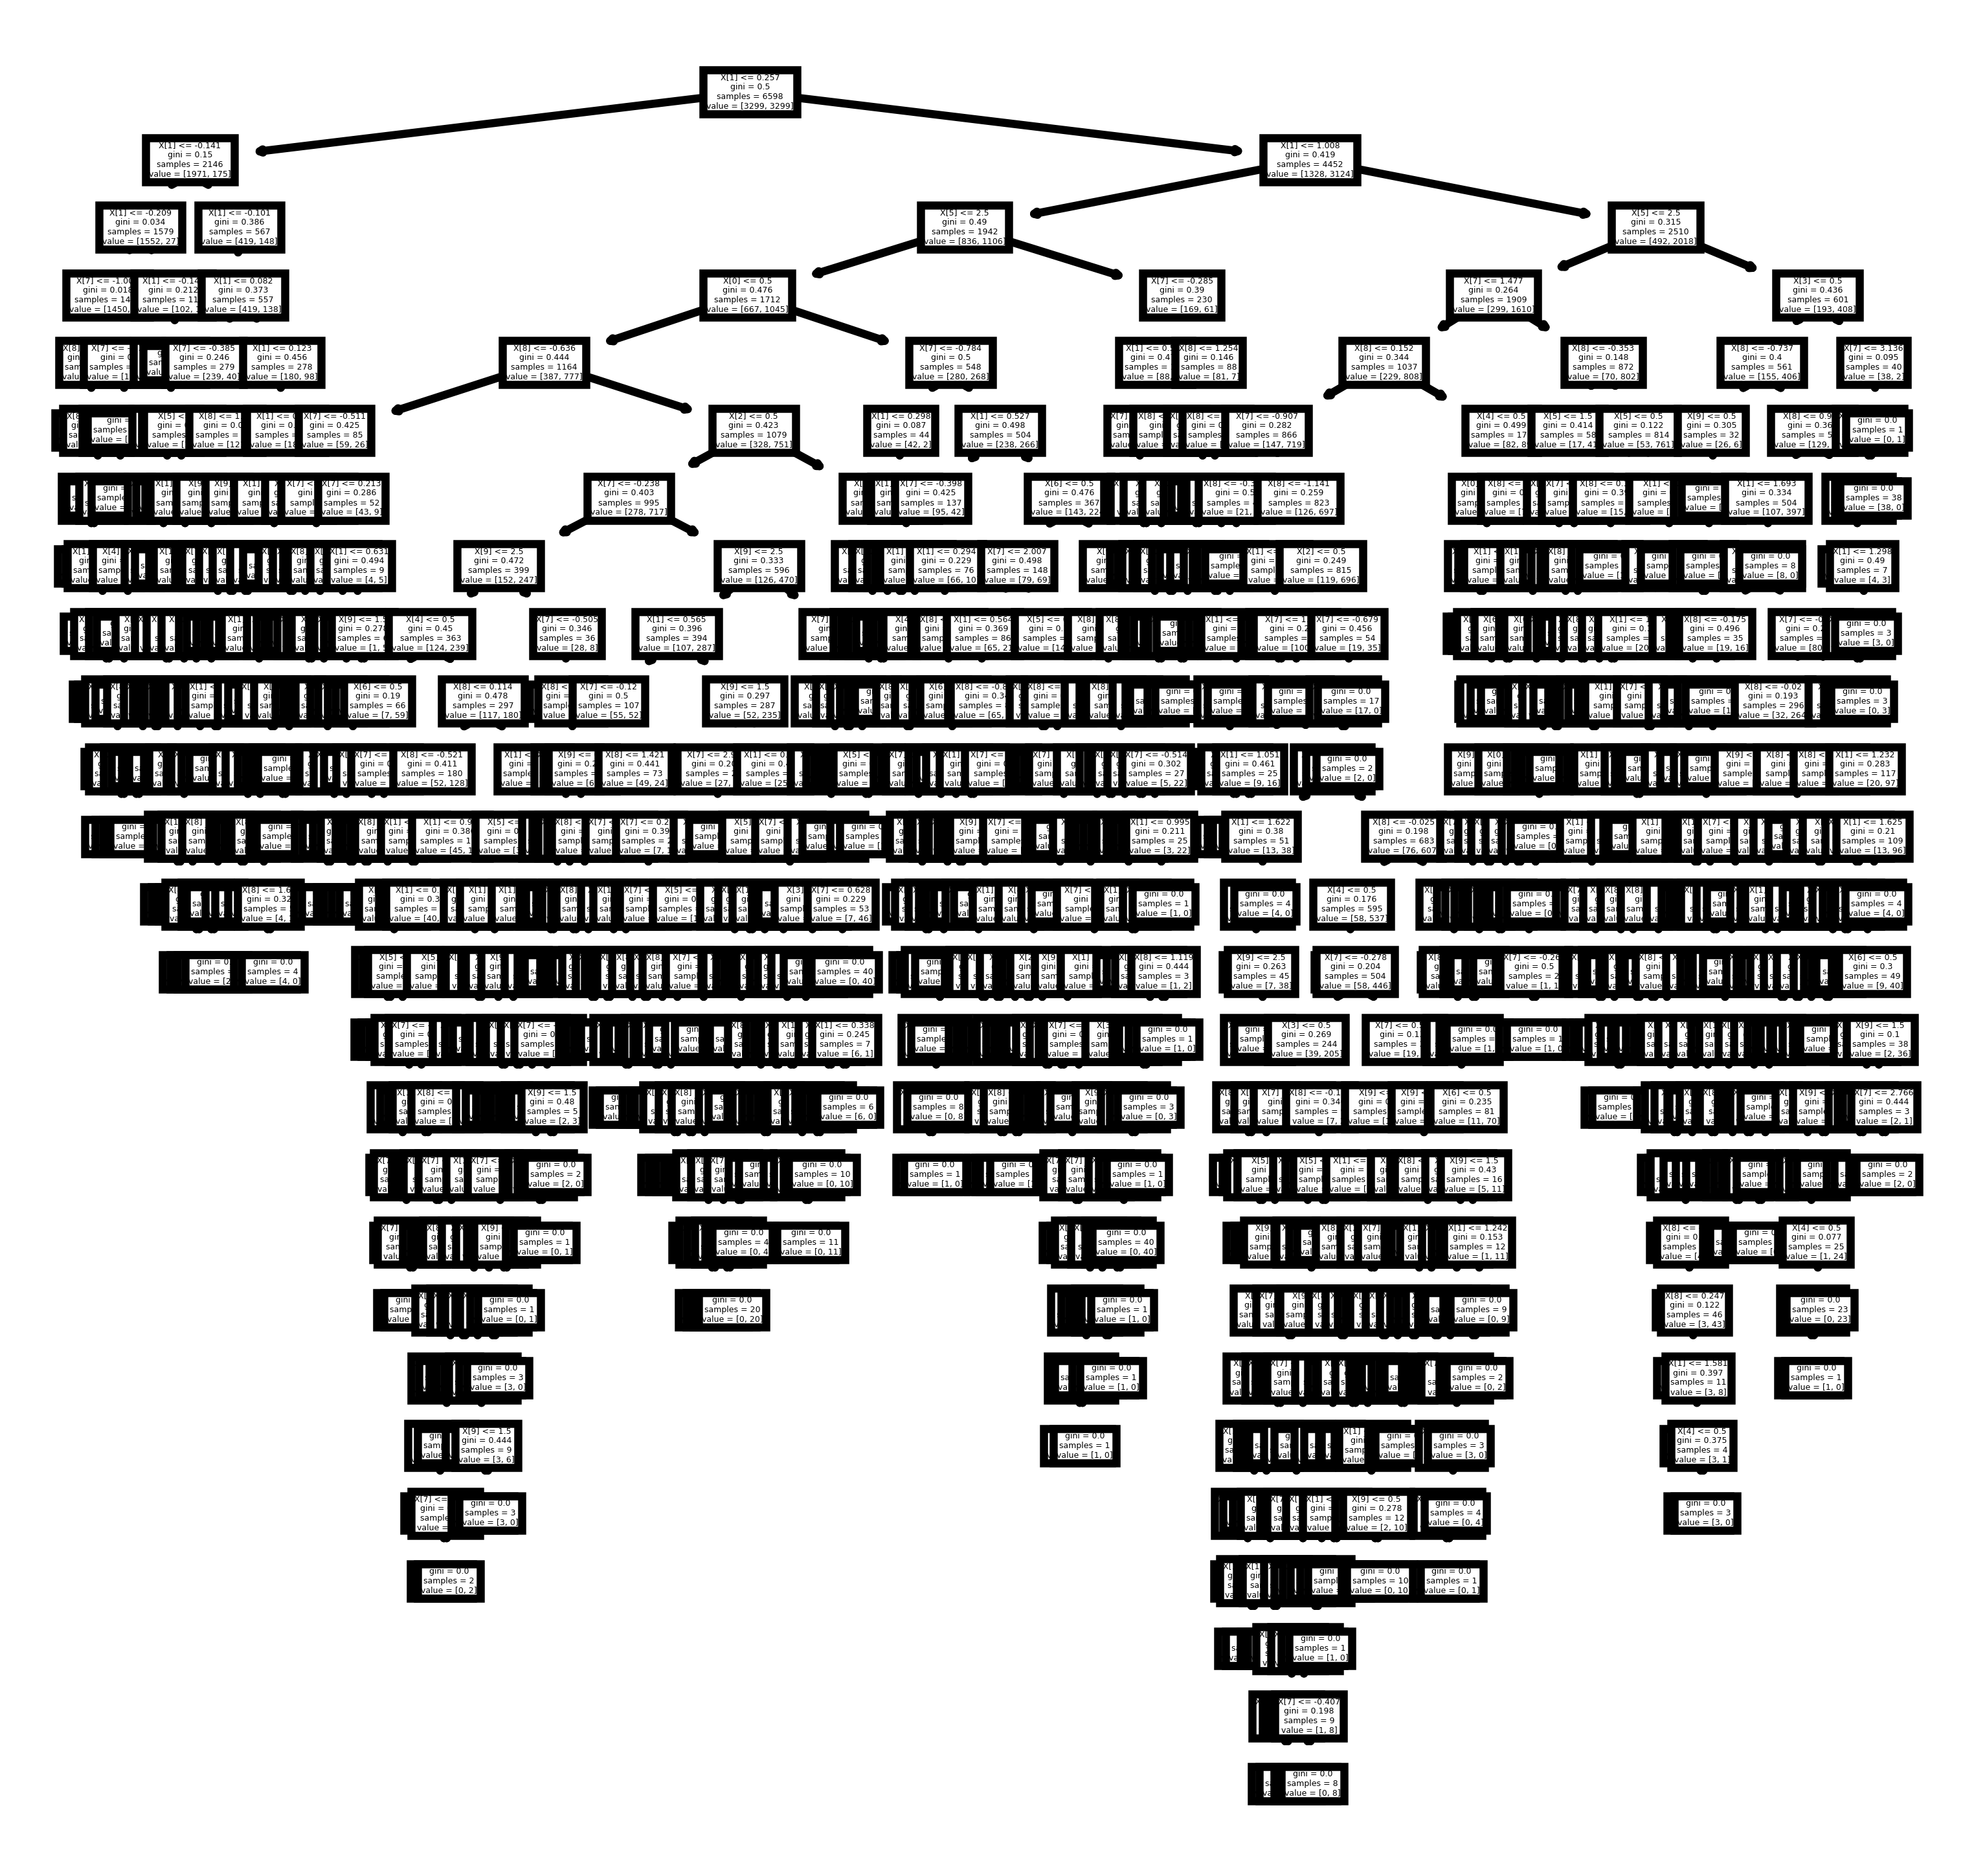

In [171]:
fig, axes = plt.subplots(nrows = 1,ncols = 1,figsize = (4,4), dpi=900)
tree.plot_tree(clf)
fig.savefig('imagename.png')

In [25]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler

rfc = RandomForestClassifier()
rfc.fit(X_train_SMOTE.to_numpy(), y_train_SMOTE.values.flatten())
rfc_predict = rfc.predict(X_test)

#rf_pipeline = Pipeline(steps = [('scale',StandardScaler()),('RF',RandomForestClassifier(random_state=42))])
#rf_cv = cross_val_score(rf_pipeline,X_train_SMOTE,y_train_SMOTE,cv=10,scoring='f1')
#print('Random Forest mean :',cross_val_score(rf_pipeline,X_train_SMOTE,y_train_SMOTE,cv=10,scoring='f1').mean())

In [26]:
Counter(rfc_predict)

Counter({1: 133, 0: 1340})

# CHAPTER 5 - CONCLUSIONS <a class="anchor" id="5"></a>